#                          TRANSFORMERS

The Transformer in NLP is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease.                                           
It **relies entirely on self-attention to compute representations of its input and output WITHOUT using sequence-aligned RNNs or convolution.** This mechanism allows them to capture long-range dependencies and relationships between words more effectively than previous models. As a result, Transformers have achieved state-of-the-art performance in many NLP tasks, including language translation, text summarization, question answering, and sentiment analysis.

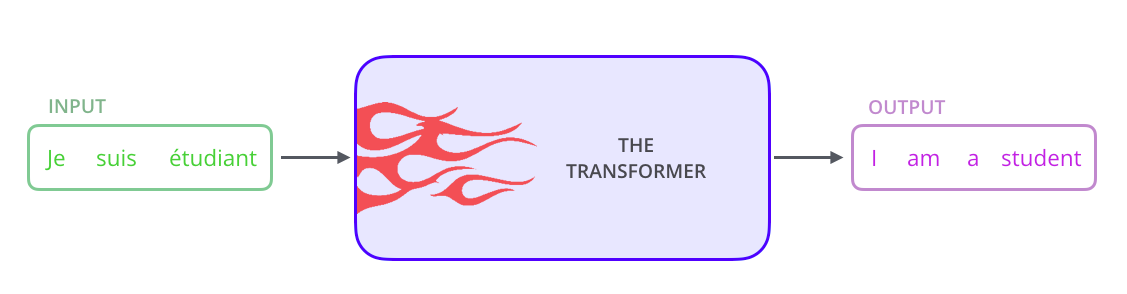

Popping open that Optimus Prime goodness, we see an encoding component, a decoding component, and connections between them.(we have opened transformer component and shown in below image)

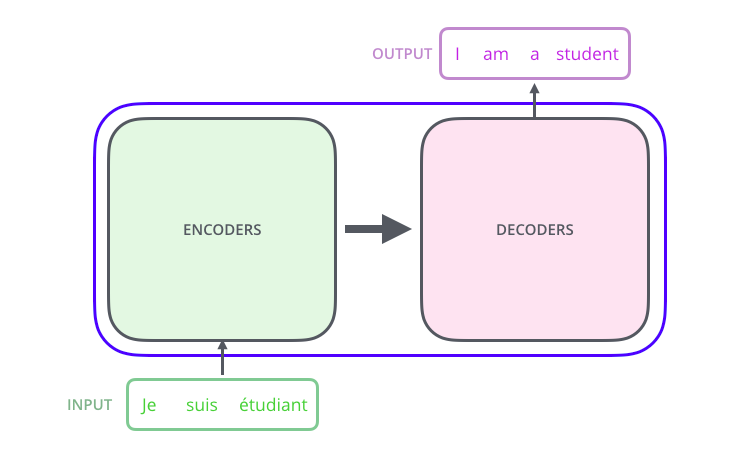

The encoding component is a stack of encoders (the paper stacks six of them on top of each other – there’s nothing magical about the number six, one can definitely experiment with other arrangements). The decoding component is a stack of decoders of the same number.

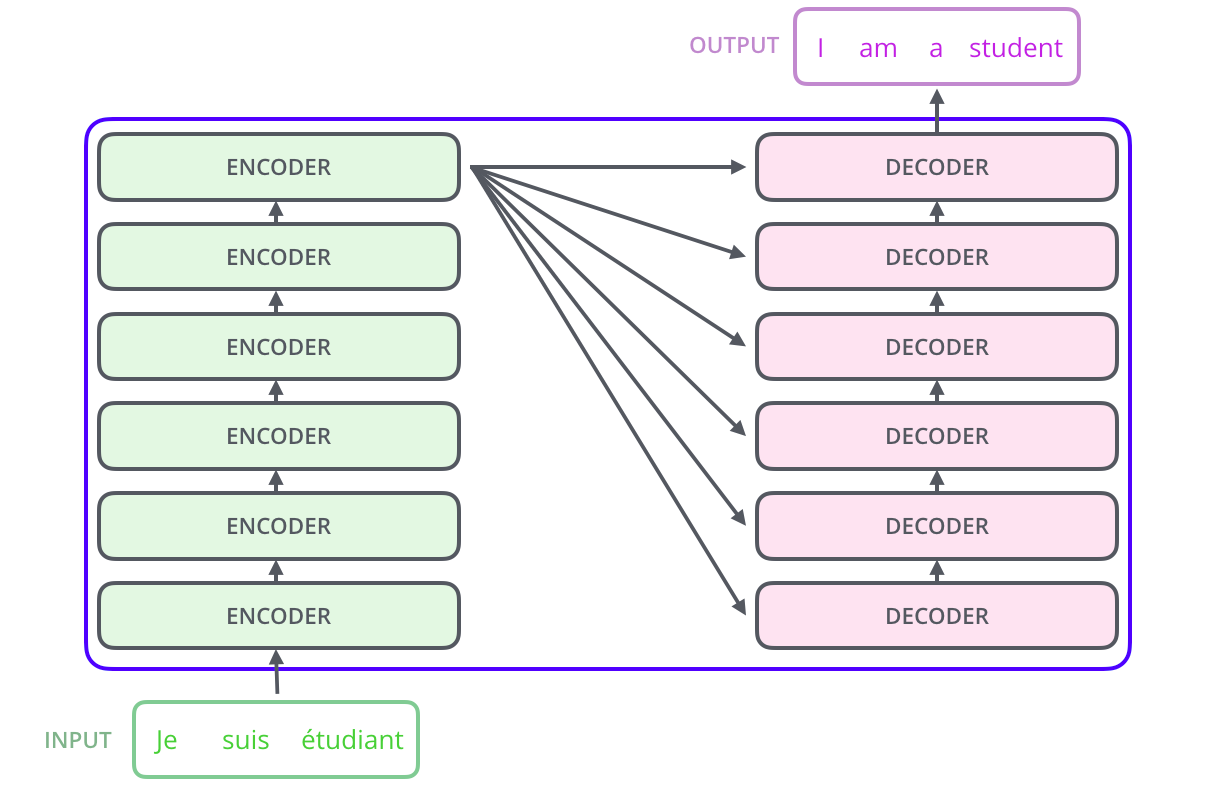

The encoders are all identical in structure (yet they do not share weights). Each one is broken down into two sub-layers:

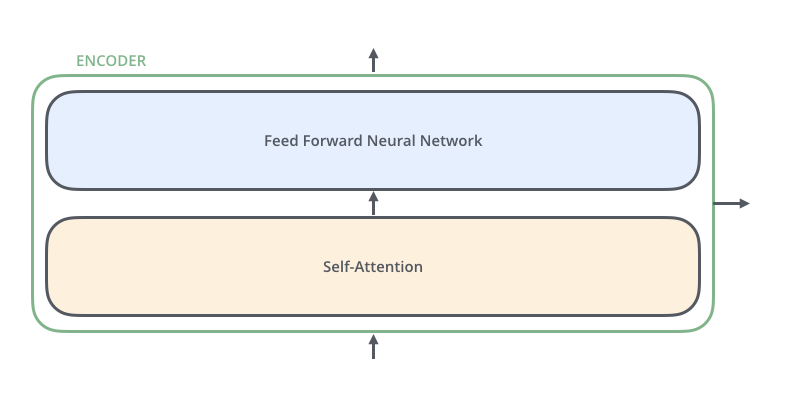

The encoder’s inputs first flow through a **self-attention layer** – a layer that **helps the encoder look at other words in the input sentence as it encodes a specific word.**

The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.

The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence 

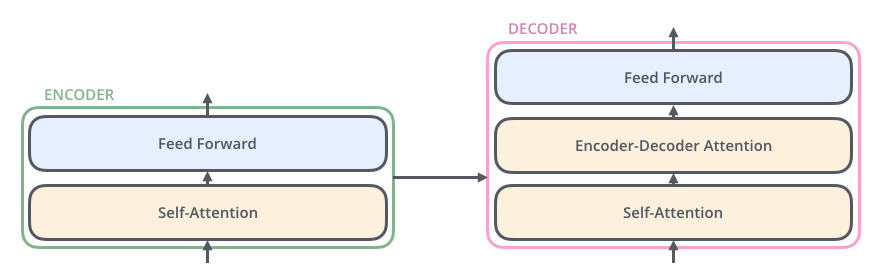

# Bringing The Tensors Into The Picture

As is the case in NLP applications in general, we begin by turning each input word into a vector using an embedding algorithm.

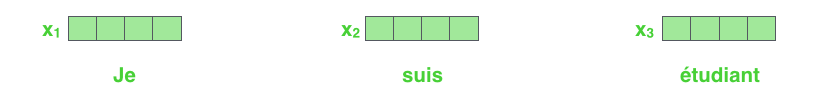

The embedding only happens in the bottom-most encoder. The abstraction that is common to all the encoders is that they receive a list of vectors each of the size 512 – In the bottom encoder that would be the word embeddings, but in other encoders, it would be the output of the encoder that’s directly below. The size of this list is hyperparameter we can set – basically it would be the length of the longest sentence in our training dataset.

After embedding the words in our input sequence, each of them flows through each of the two layers of the encoder.
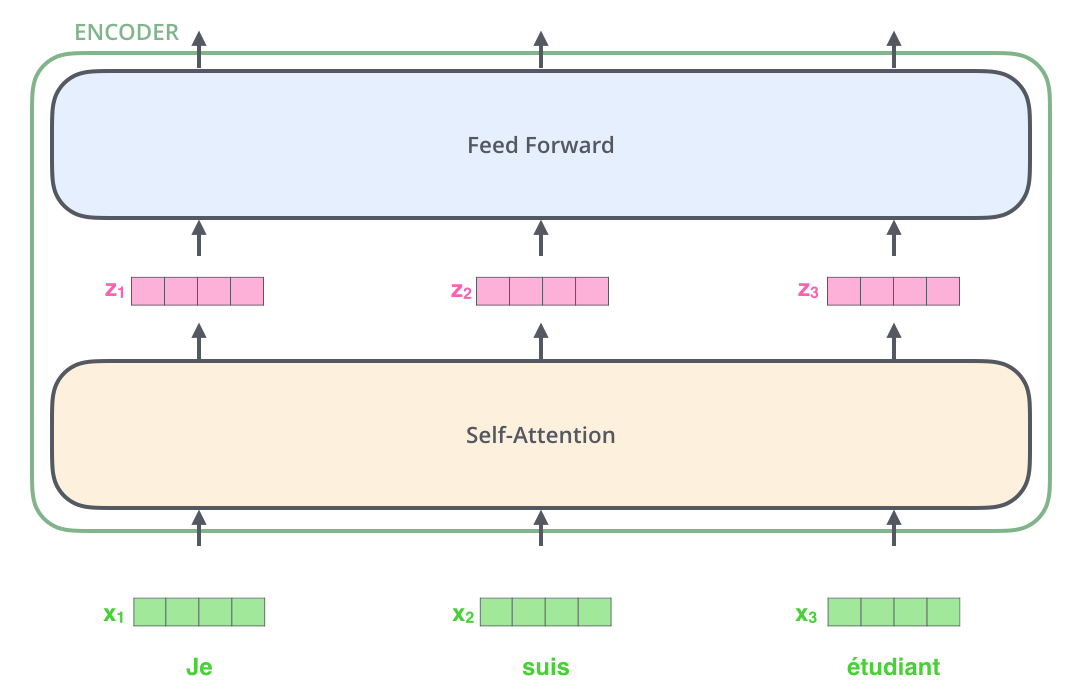

**Note:-** Input needs to give parallely.

# Now We’re Encoding!

As we’ve mentioned already, an encoder receives a list of vectors as input. It processes this list by passing these vectors into a ‘self-attention’ layer, then into a feed-forward neural network, then sends out the output upwards to the next encoder.

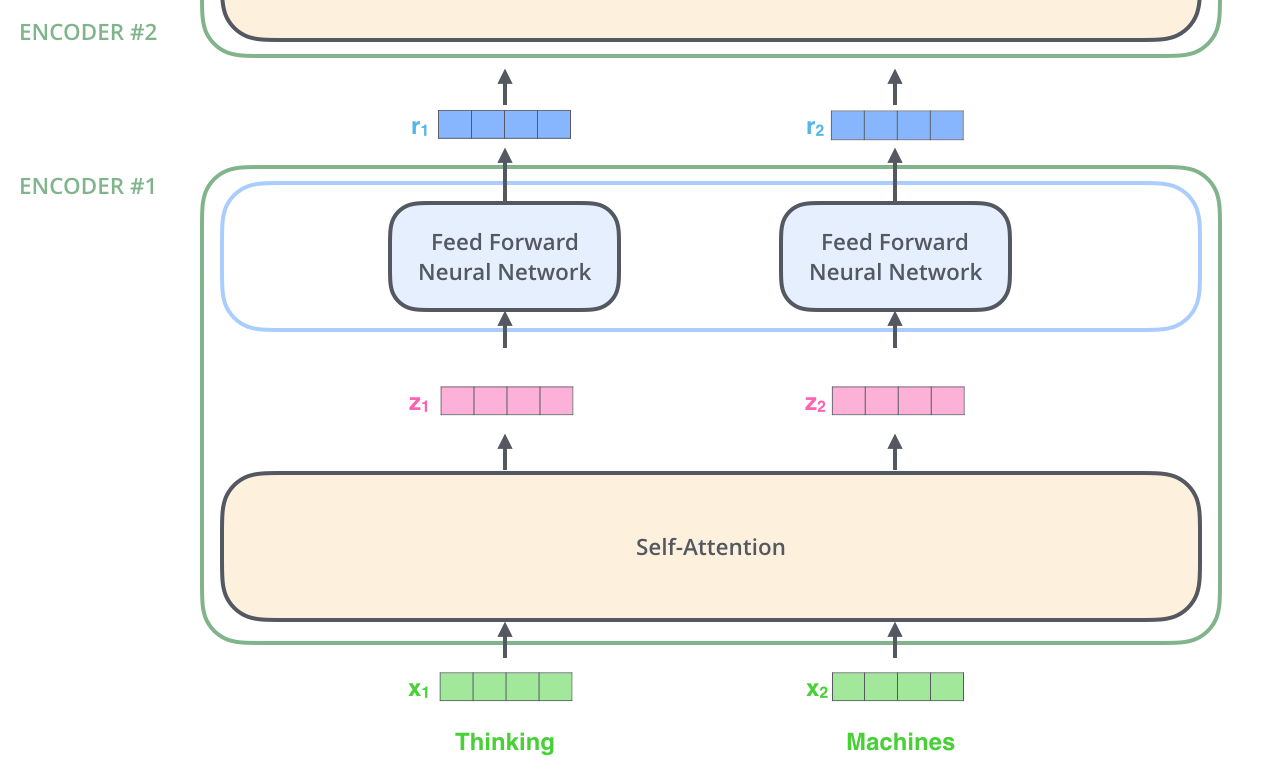

# Self-Attention at a High Level

Say the following sentence is an input sentence we want to translate:

”The animal didn't cross the street because it was too tired”

What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.

When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.

As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word. If you’re familiar with RNNs, think of how maintaining a hidden state allows an RNN to incorporate its representation of previous words/vectors it has processed with the current one it’s processing. Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing.

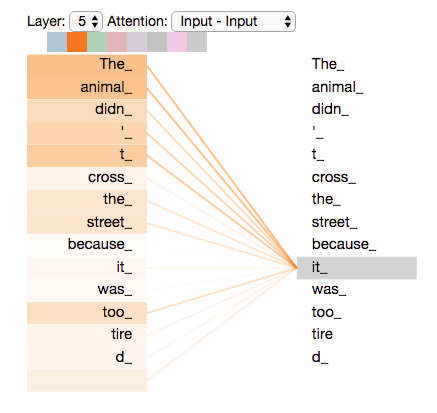

# Self-Attention in Detail

The **first step** in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.

**Notice that these new vectors are smaller in dimension than the embedding vector**. Their dimensionality is 64, while the embedding and encoder input/output vectors have dimensionality of 512. They don’t HAVE to be smaller, this is an architecture choice to make the computation of multiheaded attention (mostly) constant.

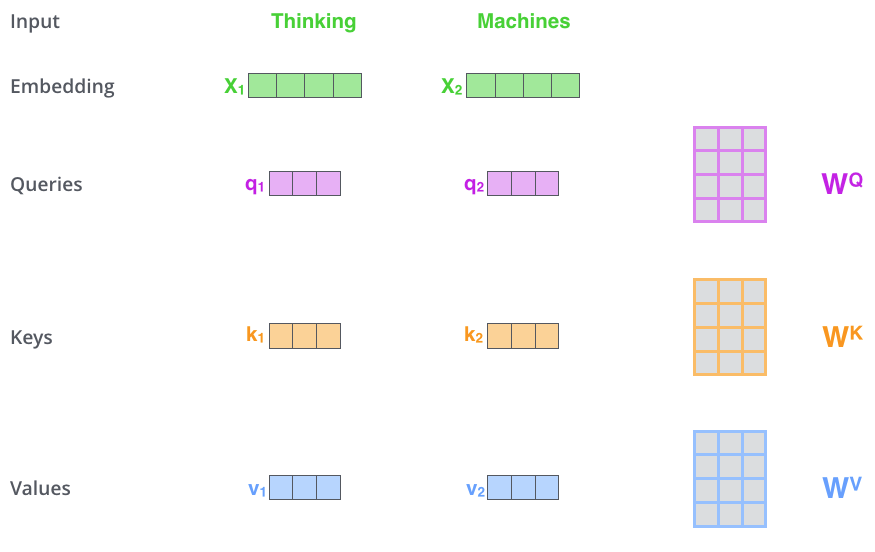

The **second step** in calculating self-attention is to calculate a score. Say we’re calculating the self-attention for the first word in this example, “Thinking”. We need to score each word of the input sentence against this word. The score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position.

The score is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring. So if we’re processing the self-attention for the word in position #1, the first score would be the dot product of q1 and k1. The second score would be the dot product of q1 and k2.

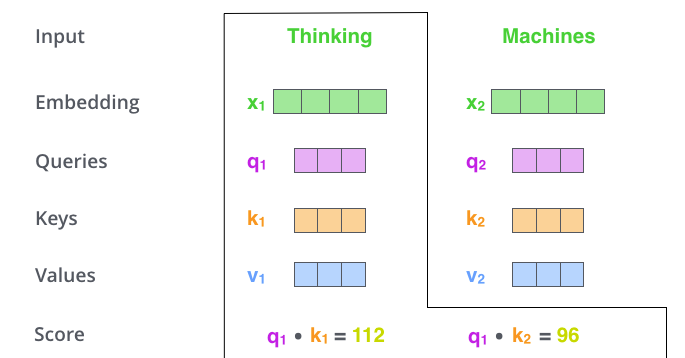

The **third and fourth steps** are to **divide the scores by 8** (the square root of the dimension of the key vectors used in the paper – 64. This leads to having more stable gradients. There could be other possible values here, but this is the default), then pass the result through a softmax operation. Softmax normalizes the scores so they’re all positive and add up to 1.

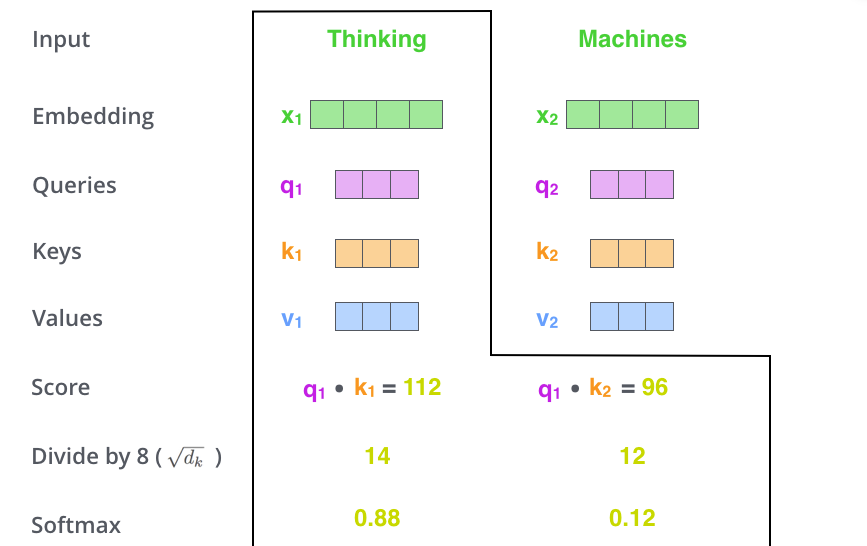

**Note:-** The summation of softmax values should be 1. for eg :- 0.88 + 0.12 = 1

This softmax score determines how much each word will be expressed at this position. Clearly the word at this position will have the highest softmax score, but sometimes it’s useful to attend to another word that is relevant to the current word.

The **fifth step** is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

The **sixth step** is to sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

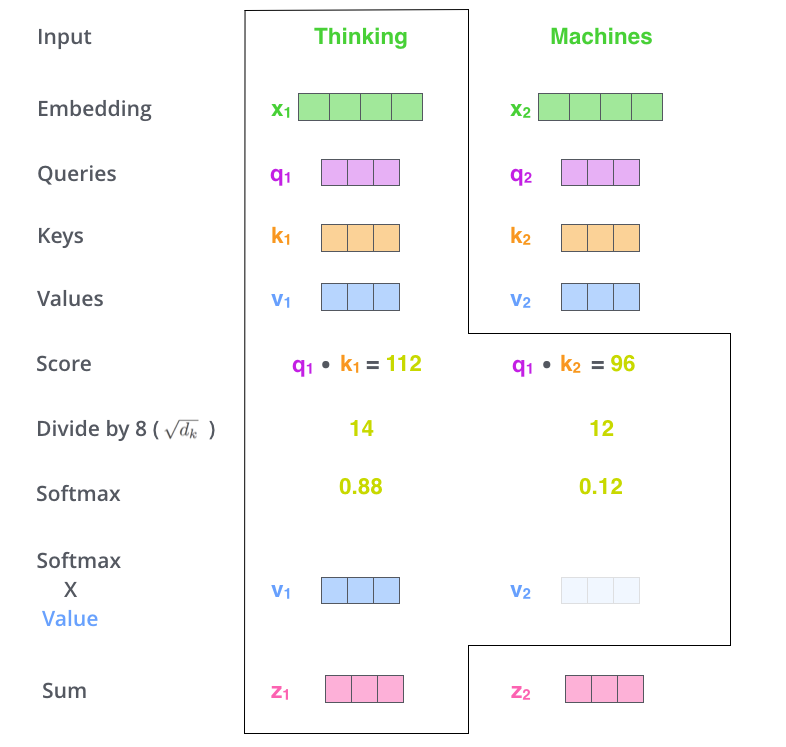

The resulting vector is one we can send along to the feed-forward neural network. In the actual implementation, however, this calculation is done in matrix form for faster processing. So let’s look at that now that we’ve seen the intuition of the calculation on the word level.

# Matrix Calculation of Self-Attention

The first step is to calculate the Query, Key, and Value matrices. We do that by packing our embeddings into a matrix X, and multiplying it by the weight matrices we’ve trained (WQ, WK, WV).

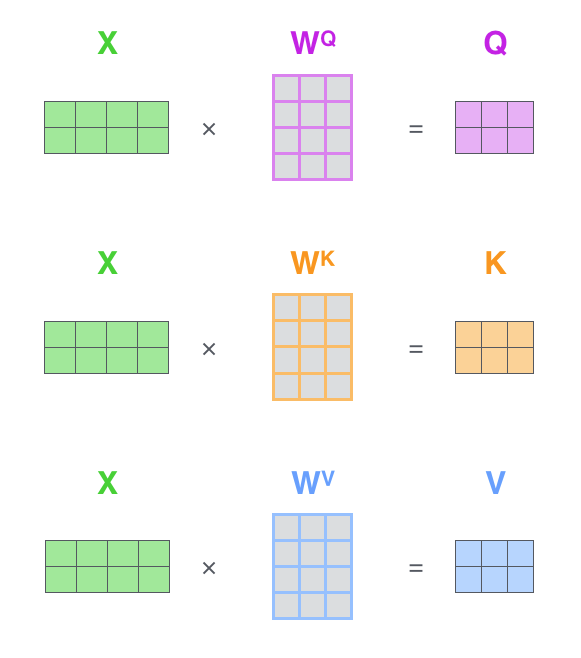

Finally, since we’re dealing with matrices, we can condense steps two through six in one formula to calculate the outputs of the self-attention layer.

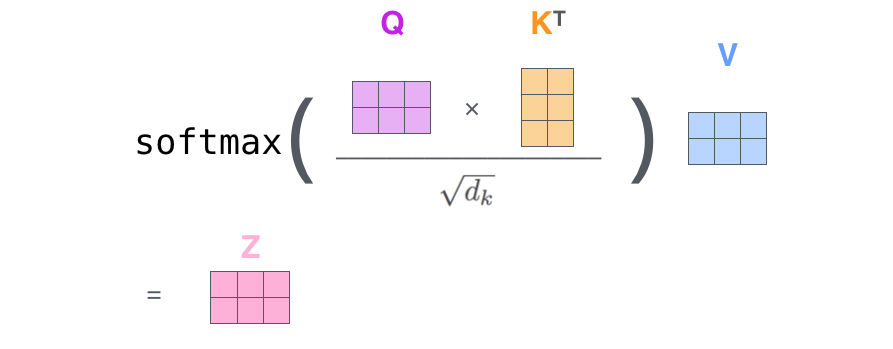

# The Beast With Many Heads

This improves the performance of the attention layer in two ways:

    It expands the model’s ability to focus on different positions. Yes, in the example above, z1 contains a little bit of every other encoding, but it could be dominated by the actual word itself. If we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, it would be useful to know which word “it” refers to.

    It gives the attention layer multiple “representation subspaces”. As we’ll see next, with multi-headed attention we have not only one, but multiple sets of Query/Key/Value weight matrices (the Transformer uses eight attention heads, so we end up with eight sets for each encoder/decoder). Each of these sets is randomly initialized. Then, after training, each set is used to project the input embeddings (or vectors from lower encoders/decoders) into a different representation subspace.

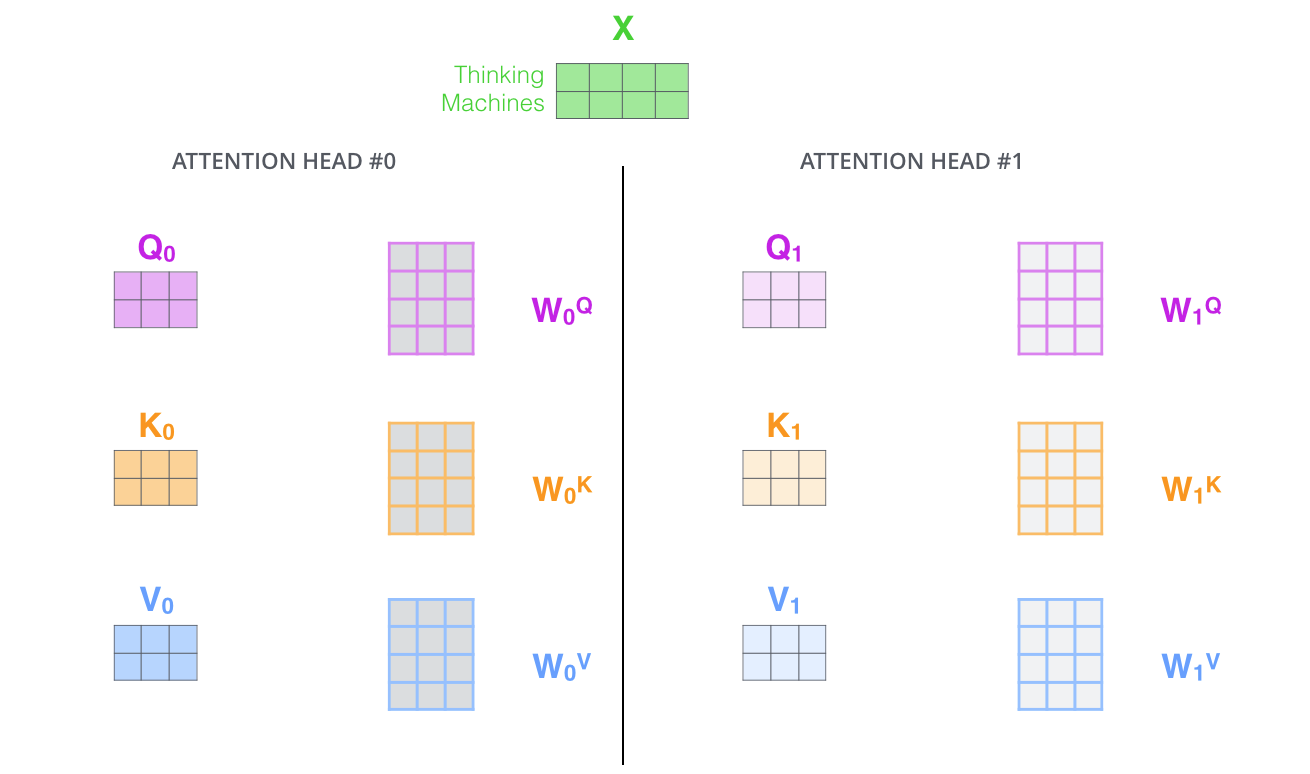

If we do the same self-attention calculation we outlined above, just eight different times with different weight matrices, we end up with eight different Z matrices

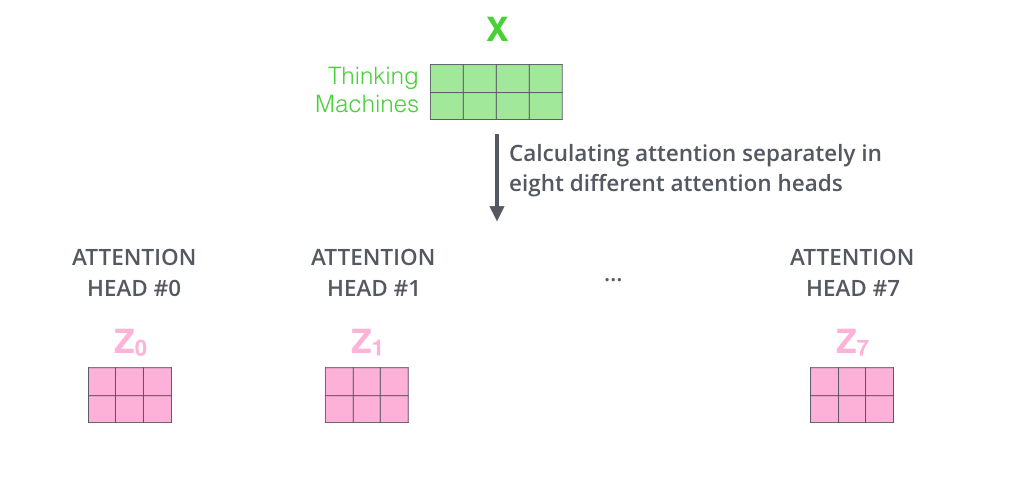

This leaves us with a bit of a challenge. The feed-forward layer is not expecting eight matrices – it’s expecting a single matrix (a vector for each word). So we need a way to condense these eight down into a single matrix.

How do we do that? We concat the matrices then multiply them by an additional weights matrix WO.

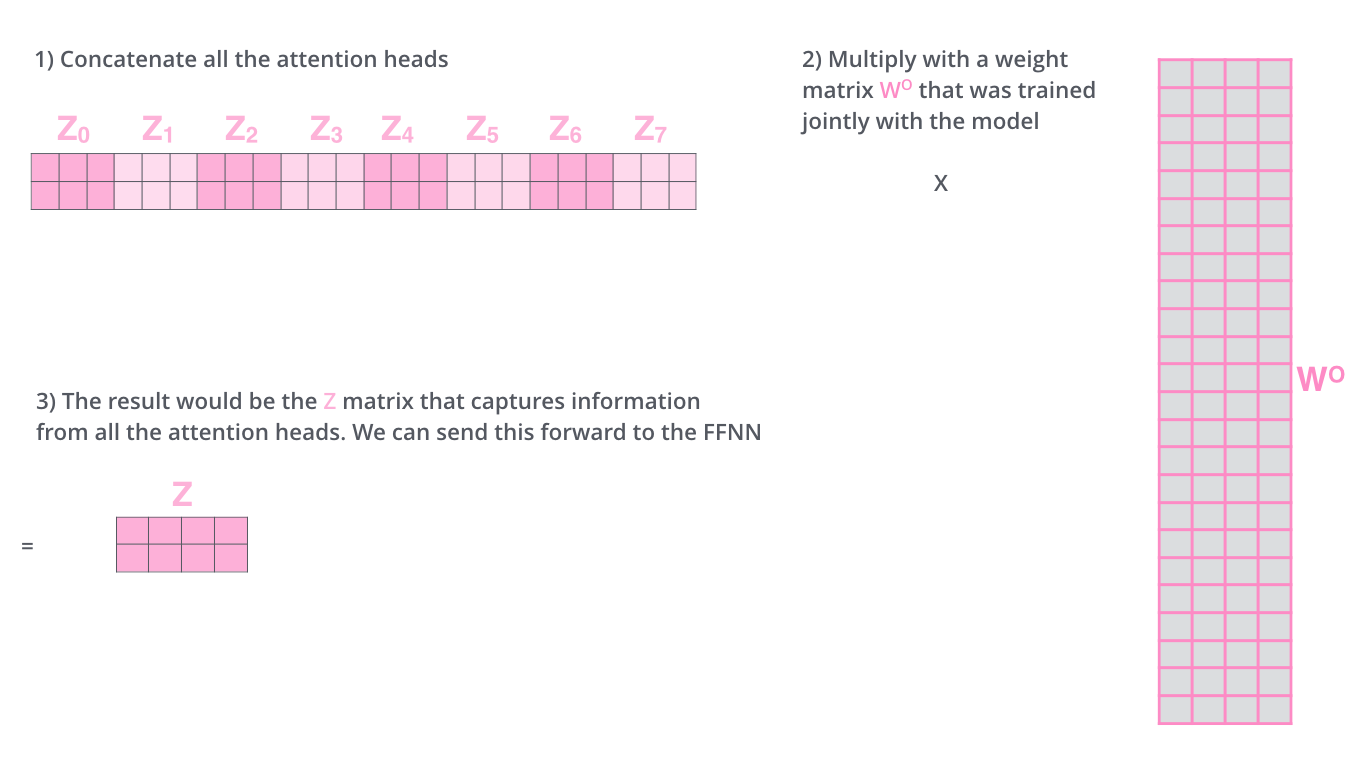

Let me try to put them all in one visual so we can look at them in one place
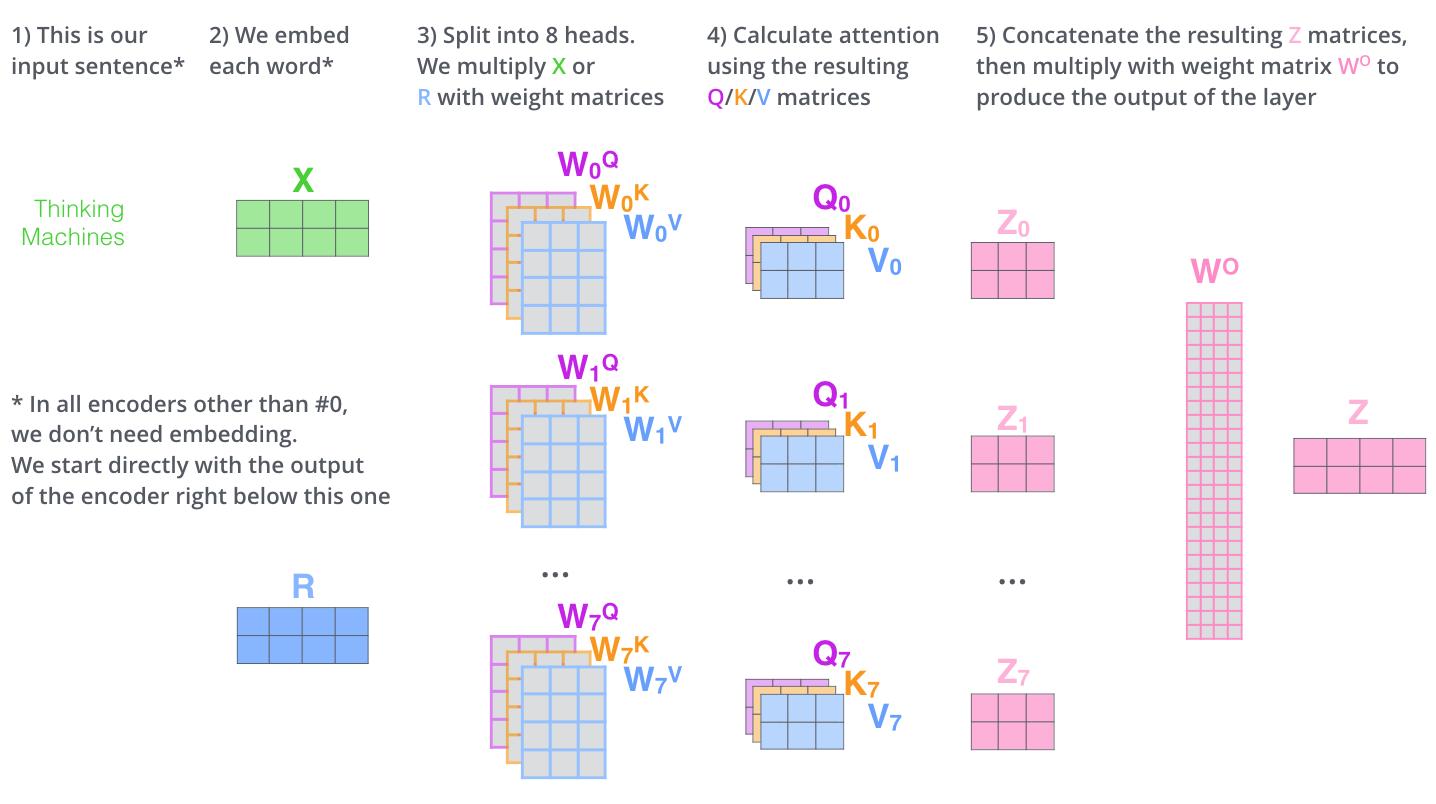

Now that we have touched upon attention heads, let’s revisit our example from before to see where the different attention heads are focusing as we encode the word “it” in our example sentence:
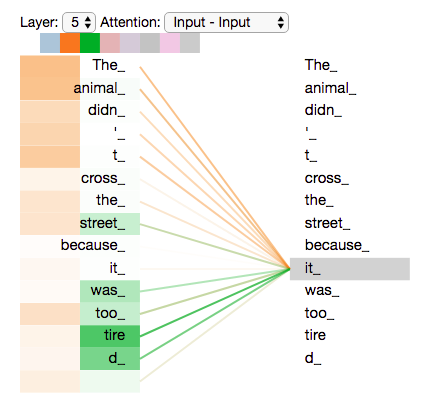

As we encode the word "it", one attention head is focusing most on "the animal", while another is focusing on "tired" -- in a sense, the model's representation of the word "it" bakes in some of the representation of both "animal" and "tired".

If we add all the attention heads to the picture, however, things can be harder to interpret:

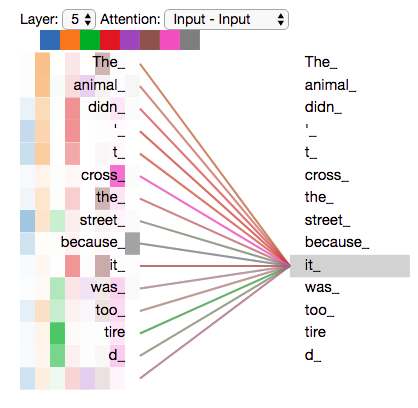

# Representing The Order of The Sequence Using Positional Encoding

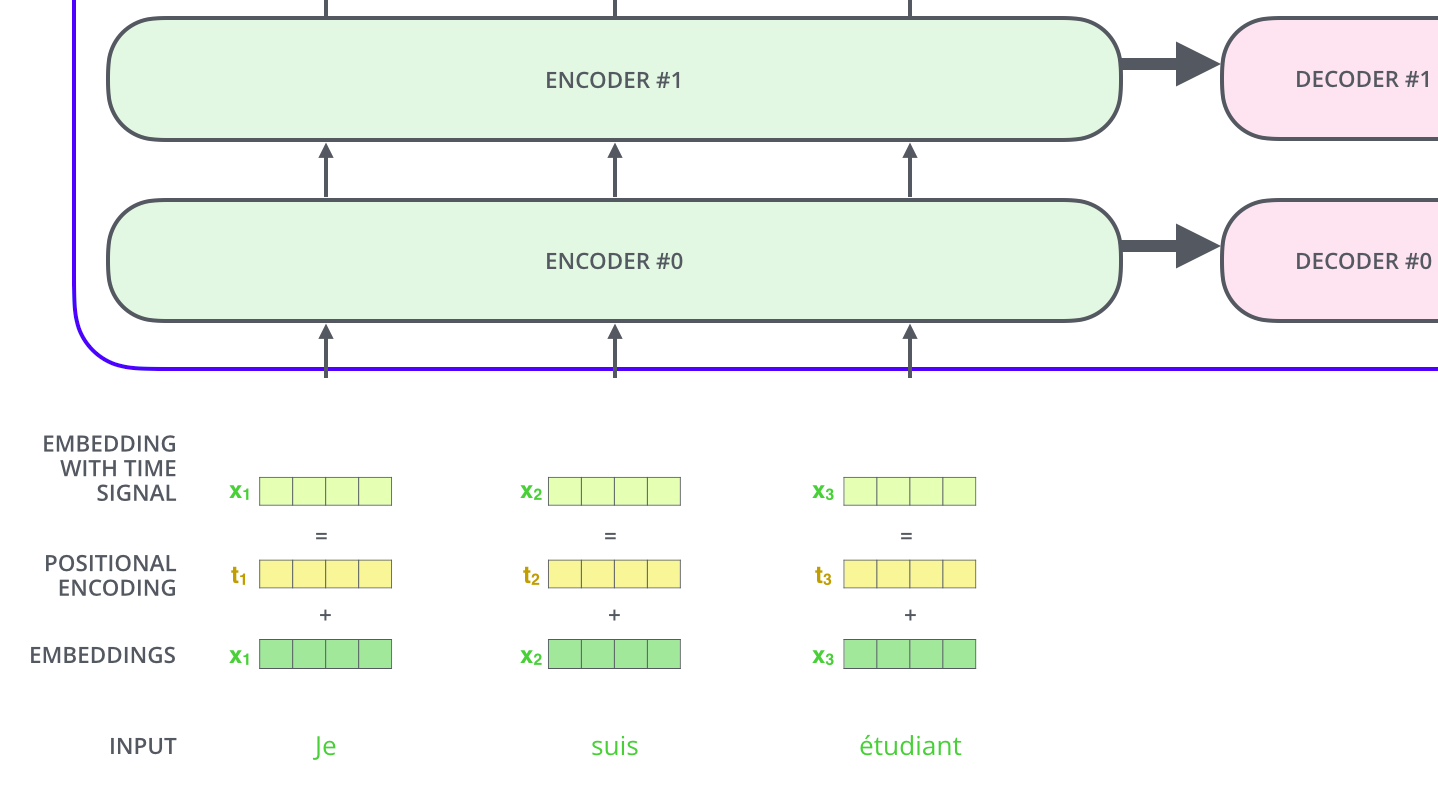

To give the model a sense of the order of the words, we add positional encoding vectors -- the values of which follow a specific pattern. 

If we assumed the embedding has a dimensionality of 4, the actual positional encodings would look like this:
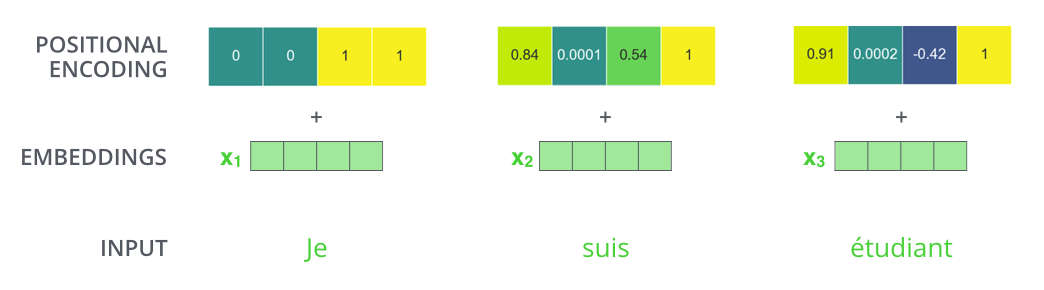

# The Residuals

One detail in the architecture of the encoder that we need to mention before moving on, is that each sub-layer (self-attention, ffnn) in each encoder has a residual connection around it, and is followed by a layer-normalization step.
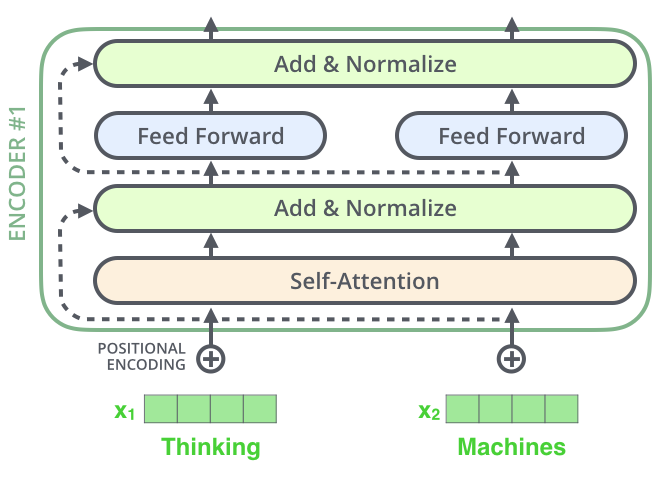

If we’re to visualize the vectors and the layer-norm operation associated with self attention, it would look like this:
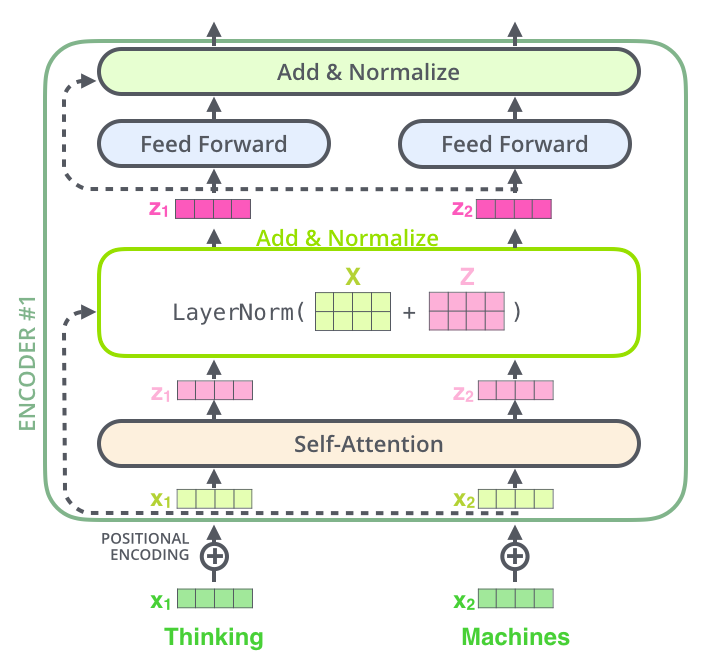

This goes for the sub-layers of the decoder as well. If we’re to think of a Transformer of 2 stacked encoders and decoders, it would look something like this:
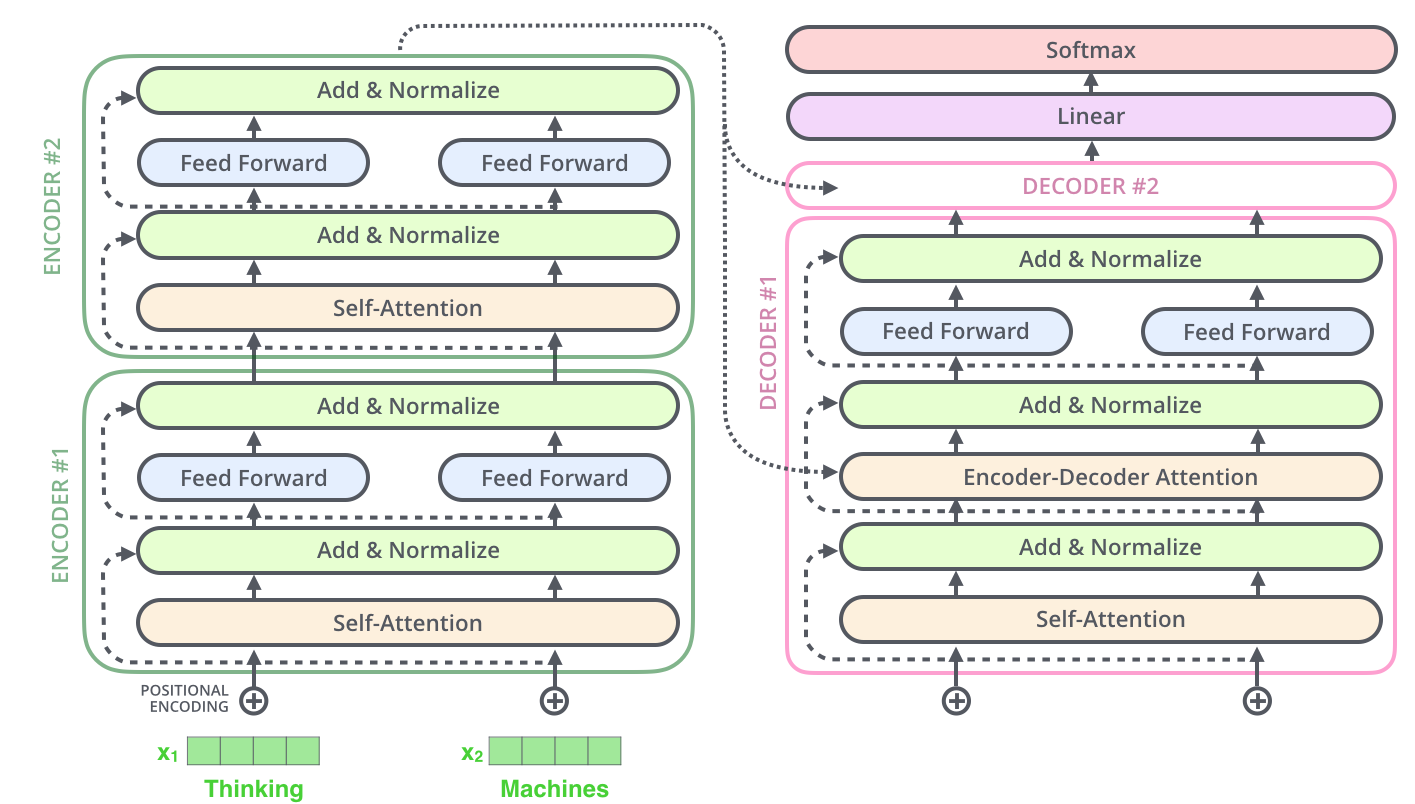

# The Decoder Side

Now that we’ve covered most of the concepts on the encoder side, we basically know how the components of decoders work as well. But let’s take a look at how they work together.

The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence:

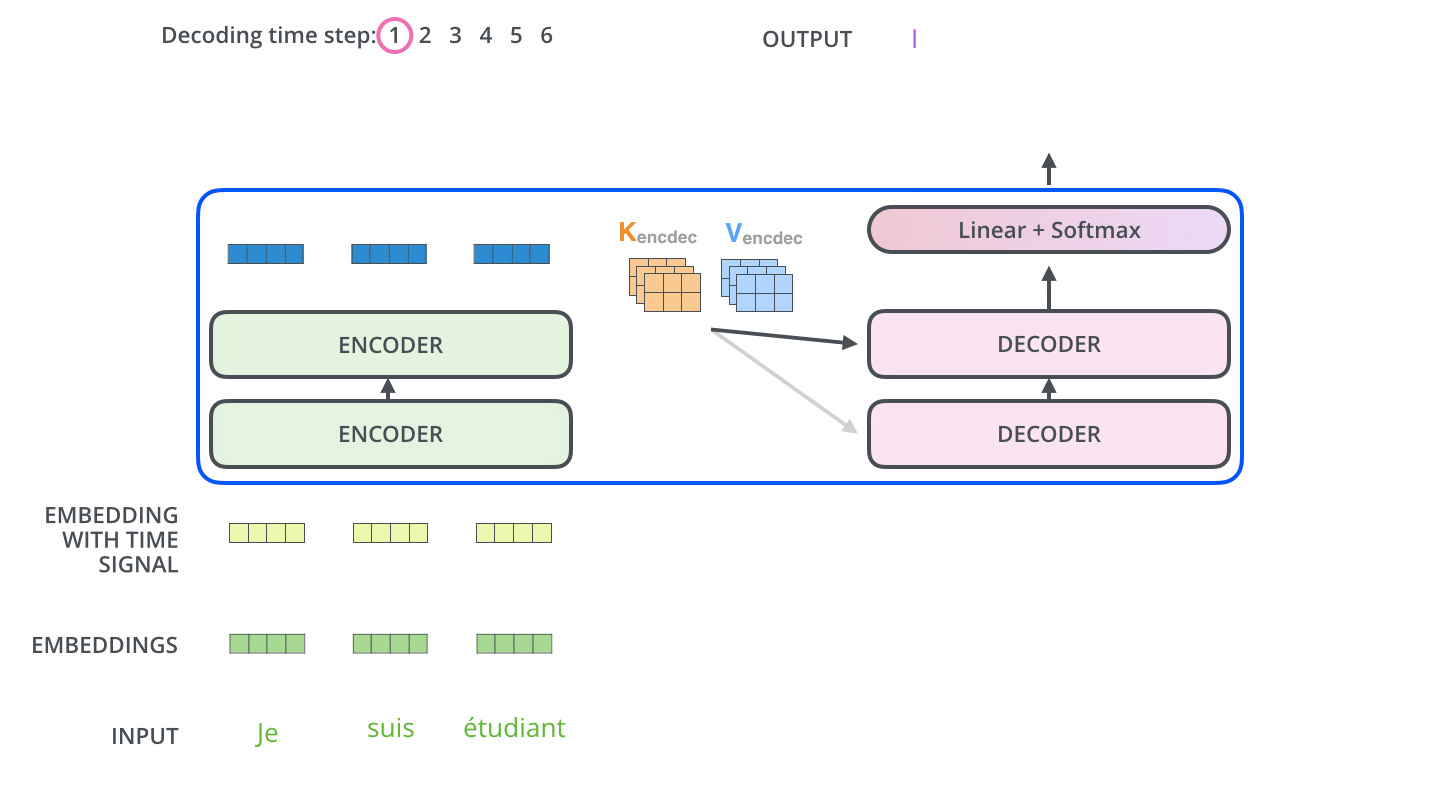

After finishing the encoding phase, we begin the decoding phase. Each step in the decoding phase outputs an element from the output sequence (the English translation sentence in this case). 

The following steps repeat the process until a special symbol is reached indicating the transformer decoder has completed its output. The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

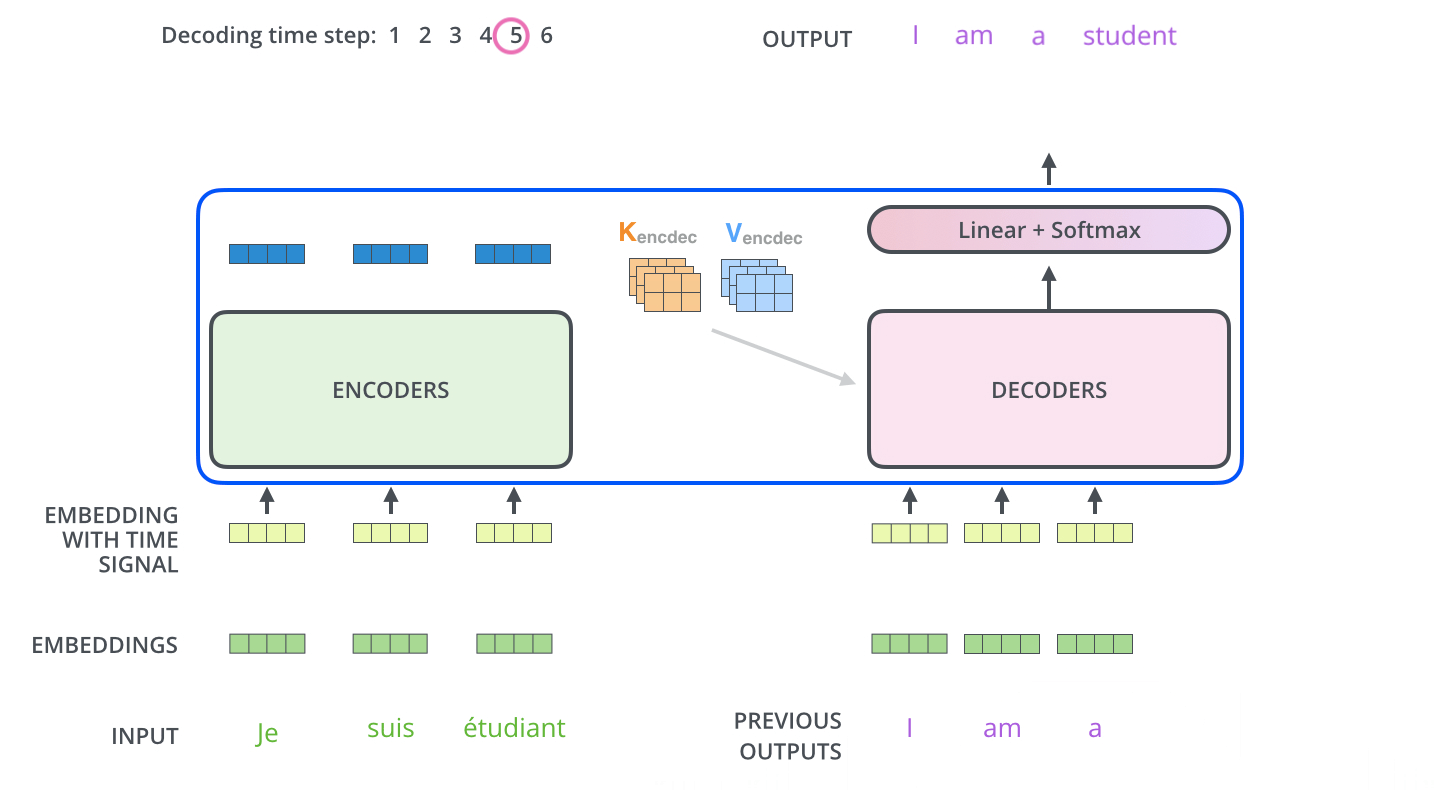

The self attention layers in the decoder operate in a slightly different way than the one in the encoder:

In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.